In [1]:
import matplotlib.pyplot as plt
from src.plot_utils import *
from src.sim_utils import *
import yaml
import numpy as np
import jax.numpy as jnp
import sparse
from hydra import initialize, compose
from hydra.core.hydra_config import HydraConfig
from omegaconf import DictConfig, OmegaConf
from pathlib import Path, PosixPath
import h5py

In [2]:
# # PLOT defaults
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["axes.spines.right"] = "False"
plt.rcParams["axes.spines.top"] = "False"
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["figure.figsize"] = (2,2)
plt.rcParams['axes.linewidth'] = 0.25
plt.rcParams["xtick.major.size"] = 1.7
plt.rcParams["xtick.minor.size"] = 1.0
plt.rcParams["ytick.major.size"] = 1.7
plt.rcParams["xtick.major.width"] = 0.25
plt.rcParams["xtick.minor.width"] = 0.18
plt.rcParams["ytick.major.width"] = 0.25
plt.rcParams["figure.dpi"] = 200

plt.rcParams["axes.labelpad"] = 1.5
plt.rcParams["xtick.major.pad"] = 1.5
plt.rcParams["ytick.major.pad"] = 1.5

SMALL_SIZE = 6
LABEL_SIZE = 7
AXLABEL_SIZE = 8
TITLE_SIZE = 10

plt.rcParams["font.family"] = "Arial" # "Arial"
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=AXLABEL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=LABEL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=TITLE_SIZE)  # fontsize of the figure title

moduleColors = get_module_colors()

dnColor = "#51bbad"
excColor = "#d84a2e"
inhColor = "#026b85"
mnColor = "#267655"

lightDnColor = "#a7dcd5ff"
lightExcColor = "#ff9985"

dataPath = "/data/users/smpuglie/Pugliese_2025/"

## MANC 1024x DNb08 activation

In [3]:
simType = "DNb08_Stim"
simPath = simType+"/hyak/run_id=28357516"
folder = dataPath + simPath
Rs = sparse.load_npz(folder+f"/ckpt/{simType}_Rs.npz").todense()
params = DictConfig(load_from_yaml(folder+"/logs/run_config.yaml"))

dataset = 0
Rs = Rs[dataset]
nSims = Rs.shape[0]
Rs.shape

(1024, 4604, 2001)

In [4]:
wTable = pd.read_csv("../"+params.experiment["dfPath"].split("Pugliese_2025")[1])
mnData = sort_motor_modules(wTable.loc[wTable["motor module"].notna()])
nMnsActive = pd.Series(index=np.arange(nSims))
nMnsActiveTinyThreshold = pd.Series(index=np.arange(nSims))
simScore = pd.Series(index=np.arange(nSims))

for i in range(nSims):
    # active neurons
    R = Rs[i]
    
    activeMnsMask = (np.max(R,1)>0.01) & (jnp.isin(jnp.arange(R.shape[0]), mnData.index.to_numpy()))
    nMnsActive.loc[i] = np.sum(activeMnsMask)
    activeMnsMaskPastTransient = (np.max(R[:,250:],1)>0.01) & (jnp.isin(jnp.arange(R.shape[0]), mnData.index.to_numpy()))
    score, _ = compute_oscillation_score(R[...,250:],activeMnsMaskPastTransient)
    nMnsActiveTinyThreshold.loc[i] = np.sum(activeMnsMaskPastTransient)
    simScore.loc[i] = score

figFolder = "../figures/"
figFolder += "-".join(str.split(simPath,"/"))

/home/smpuglie/Pugliese_2025/src/plot_utils.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neuronData[colName] = pd.Categorical(neuronData[colName],categories=["coxa swing", "coxa stance", "femur/tr extend", "femur/tr flex",


### individual traces

672
0.9685131311416626


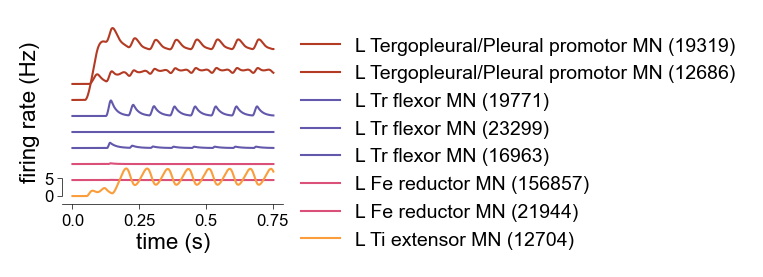

In [56]:
idx = np.random.randint(1000) 
spacer = 4.5
width = 3

R = Rs[idx]

plt.figure()
print(idx)
ax = plot_R_traces_stacked_by_module(R[:,:750],mnData,activeOnly=True,space=spacer)# ,colorMapper=colorMapper)
add_tAxis(ax,0.75,3.0001)
xlimits = ax.get_xlim()
plt.vlines(xlimits[0],0,5,"k",linewidth=0.25)
plt.yticks([0,5])
plt.xlim(xlimits)
ax.spines[["left","top","right"]].set_visible(False)
ax.tick_params(labelsize=6)
ax.grid(False)
plt.xlabel("time (s)")
fig = plt.gcf()
fig.set_figwidth(1.426)
fig.set_figheight(1.2)

print(simScore[idx])

plt.show()

~~634~~, ~~115~~, ~~243?~~, ~~392~~, 629, ~~545~~, ~~360~~, 552, ~~327~~

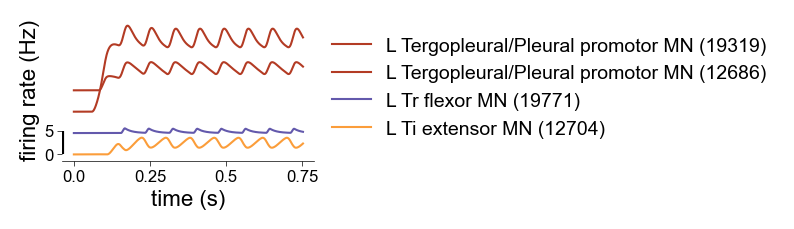

In [68]:
idx = 552 #np.random.randint(nSims)
spacer = 4.5
scalebar = 5

timeLimit = .75

R = Rs[idx]

plt.figure()
ax = plot_R_traces_stacked_by_module(R[:,:750],mnData,activeOnly=True,space=spacer)# ,colorMapper=colorMapper)
add_tAxis(ax,timeLimit,3.00001)
xlimits = ax.get_xlim()
plt.vlines(xlimits[0],0,scalebar,"k")
plt.yticks([0,scalebar])
plt.xlim(xlimits)
ax.spines[["left","top","right"]].set_visible(False)
fig = plt.gcf()
ax.grid(False)
plt.xlabel("time (s)")


fig.set_figwidth(1.626)
fig.set_figheight(1.226*3/4)
# fig.set_dpi(500)

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+f"/mnTraces_idx{idx}.svg",transparent=True)
plt.show()

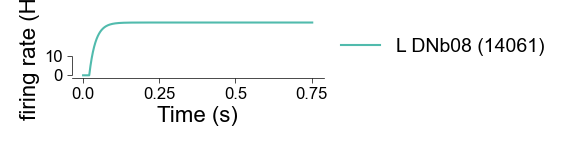

In [63]:
idx = 552 # np.random.randint(1000)
R = Rs[idx]
spacer=10

tIdxs = np.arange(0,1000)

dnb08data = wTable.loc[wTable["type"]=="DNb08"].copy()
dnb08data["somaSide"] = ["LHS","LHS","RHS","RHS"]

plt.figure()
ax = plot_R_traces_stacked_2(R[:,:750],dnb08data,activeOnly=True,space=spacer,colors=["#51bbad"])# ,colorMapper=colorMapper)
add_tAxis(ax,0.75,3.0001)
xlimits = ax.get_xlim()
plt.vlines(xlimits[0],0,10,"k",linewidth=0.25)
plt.yticks([0,10])
plt.xlim(xlimits)
ax.spines[["left","top","right"]].set_visible(False)
ax.grid(False)
plt.ylabel("firing rate (Hz)")
fig = plt.gcf()

fig.set_figwidth(1.626)
fig.set_figheight(0.377)

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+f"/dnb08trace_idx{idx}.svg",transparent=True)
plt.show()

### overall data

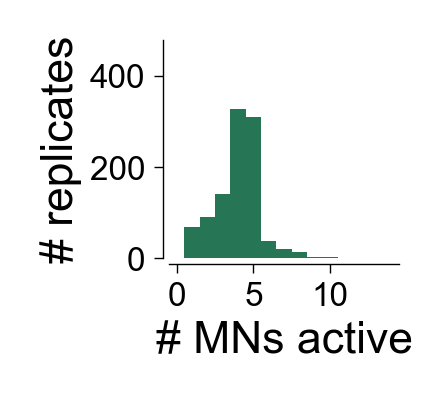

In [8]:
plt.figure(figsize=(0.743,0.710))

ax = sns.histplot(nMnsActive,color=mnColor,edgecolor="none",binwidth=1,kde=False,alpha=1,discrete=True)
plt.ylim([0,480])
plt.xlim([-0.5,14.5])
plt.xticks([0,5,10])
plt.ylabel("# replicates",fontsize=8)
plt.xlabel("# MNs active",fontsize=8)
plt.gca().tick_params(axis='both', which='major', labelsize=6)
plt.gcf().set_dpi(400)
sns.despine(offset=1)

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+"/activeMnHist.svg",transparent=True)
plt.show()

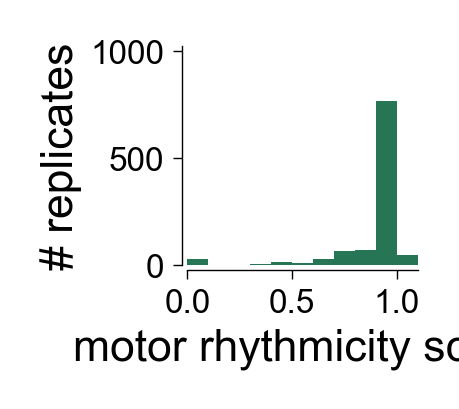

In [6]:
plt.figure(figsize=(0.743,0.710))

ax = sns.histplot(simScore,color=mnColor,edgecolor="none",bins=np.arange(0,1.5,0.1),kde=False,alpha=1.0)
plt.xlim([0,1.1])
plt.ylim([0,1024])
plt.xticks(np.arange(0,1.1,0.5))
plt.xlabel("motor rhythmicity score",fontsize=8)
plt.ylabel("# replicates",fontsize=8)
plt.gca().tick_params(axis='both', which='major', labelsize=6)
plt.gcf().set_dpi(400)
sns.despine(offset=1)

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+"/mnScoreHist.svg",transparent=True)
plt.show()

## MANC 1024x DNb08 pruning

In [ ]:
simType = "DNb08_Stim_Prune"
simPath = simType+"/hyak/run_id=28357547"
folder = dataPath + simPath
minicircuits = sparse.load_npz(folder+f"/ckpt/{simType}_mini_circuits.npz").todense()
params = DictConfig(load_from_yaml(folder+"/logs/run_config.yaml"))

dataset = 0
minicircuits = minicircuits[dataset]
nRuns = minicircuits.shape[0]

wTable = pd.read_csv("../"+params.experiment["dfPath"].split("Pugliese_2025")[1])
mnData = sort_motor_modules(wTable.loc[wTable["motor module"].notna()])

In [ ]:
minicircuitsDf = pd.DataFrame(data=minicircuits,columns = wTable.bodyId)
minicircuitsDf = minicircuitsDf.iloc[:,np.argsort(np.sum(minicircuitsDf.values, 0))]
minicircuitsDf[14061] = False #exclude DNb08
minicircuitsDf

In [ ]:
figFolder = "../figures/"
figFolder += "-".join(str.split(simPath,"/"))

In [ ]:
ax = sns.histplot(minicircuitsDf.sum(1),color=excColor,bins=np.arange(90),edgecolor=None,stat="percent",alpha=1,discrete=True)
ax.set_xlim(-0.5,14.5)
# ax.set_xlim(0,30)
# plt.yticks(np.arange(0,20,4))
ax.set_xlabel("# interneurons")
ax.set_ylabel("% of runs")
ax.set_xticks(np.arange(0,16,5))
ax.set_xticks(np.arange(0,16,1),minor=True,)
ax.tick_params(axis='both', which='major')
ax.spines[["top","right"]].set_visible(False)

plt.ylim([0,100])

fig = plt.gcf()
fig.set_figheight(0.7)
fig.set_figwidth(0.7)
# plt.gcf().set_dpi(400)
sns.despine(offset=1)

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+"/minicircuitNIns.svg",transparent=True)
plt.show()

In [ ]:
orderedInPrevalences = minicircuitsDf.transpose().sum(1).sort_values(ascending=False)
orderedInPcts = orderedInPrevalences / nRuns * 100
orderedInNts = orderedInPcts.index.map(dict(zip(wTable["bodyId"],wTable["predictedNt"])))
ntColors = {"acetylcholine":excColor,"gaba":inhColor,"glutamate":inhColor}
orderedColors = orderedInNts.map(ntColors)

In [ ]:
fig = plt.figure()
ax = orderedInPcts[:10].plot.bar(color=orderedColors[:10],width=0.8,rot=90)
plt.xticks([])
plt.ylabel("% of runs")
plt.xlabel("unique interneurons \n (10 most prevalent)")

plt.ylim([0,100])

ax.spines[["top","right"]].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=6)
fig.set_figheight(0.7)
fig.set_figwidth(1.172)
# fig.set_dpi(400)

sns.despine(offset=1)

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+"/minicircuitUniqueIns.svg",transparent=True)
plt.show()

In [ ]:
# labeled version
fig = plt.figure()
ax = orderedInPcts[:10].plot.bar(color=orderedColors[:10],width=0.8,rot=90)
# plt.xticks(rotation=45)
# plt.ylabel("% of runs")
# plt.xlabel("unique interneurons \n (10 most prevalent)")

# plt.ylim([0,100])

# ax.spines[["top","right"]].set_visible(False)
# ax.tick_params(axis='both', which='major', labelsize=6)
# fig.set_figheight(0.7)
# fig.set_figwidth(1.172)
# # fig.set_dpi(400)

# sns.despine(offset=1)

# # if not os.path.exists(figFolder):
# #     os.makedirs(figFolder)
# # plt.savefig(figFolder+"/minicircuitUniqueIns.svg",transparent=True)
# plt.show()